
<h1 style="color:black; text-align:center; font-size:24px;">FEATURE HUNTING IN LATENT SPACE</h1>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,utils
from tensorflow.keras.utils import plot_model

In [2]:
import os
import random

#loading image id's from the folder to images

folder_path = "img_align_celeba/img_align_celeba"
#C:/Users/navee/Downloads/img_align_celeba/img_align_celeba
all_images = os.listdir(folder_path)
#considering only first 20000 images
images=all_images[:20000]


# Data Preprocessing:

I have obtained images data and attribute data from different sources. 

Image data consists of 200k+ images with unique image ID's. Each image is a celebrity image. I have convereted image into an array and stored it in x variable. 

Note: Used only 10 percent(20,000 images) of the orignial data, due to hardware computaion issues

# Image Data

In [3]:
#loading all the images using image ids from the local folder to x 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

x=np.zeros((20000,64,64,3),dtype=np.uint8)
image_id=[]
for i,img in enumerate(images):
    img_path=os.path.join(folder_path,img)
    image_id.append(img)
    image=load_img(img_path, target_size=(64, 64))
    image=img_to_array(image)
    x[i]=image
      
#to converge faster
x=x/255.0


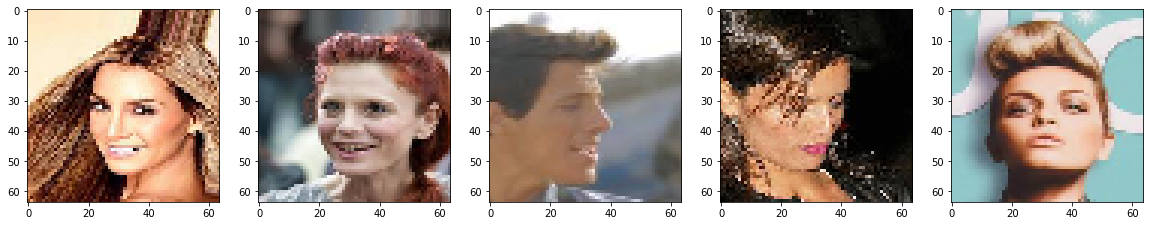

In [220]:
#displaying first 5 images in x

fig,axs=plt.subplots(1,5,figsize=(20,10))
for i in range(5):
    axs[i].imshow(x[i])
plt.show()

# Attribute data:

Attribute data I have accessed from github url. This data consists of 40 attributes each representing a particular feature on the face. Each cell contains the values 1 or -1. 1 representing the feature exists on the image, -1 representing that the feature is not on the image.


In [5]:
#getting attributes for the images in x from an url and storing it in a y
import urllib.request
url = "https://raw.githubusercontent.com/taki0112/StarGAN-Tensorflow/master/dataset/celebA/list_attr_celeba.txt"

all_lines=urllib.request.urlopen(url).readlines()[:20002]

y=[]
attribute_id=[]
for line in all_lines[2:]:
    attribute=line.decode("utf-8").split()
    y.append(attribute[1:])
    attribute_id.append(attribute[0])
    

In [7]:
#cross checking the attribute of images in y matches with images in x
i=200
print(attribute_id[i],image_id[i])

000201.jpg 000201.jpg


In [6]:
#creating list of column headers for image attribute
attribute_labels=all_lines[1].decode("utf-8").split()
print(attribute_labels)
print('----------------')
print(attribute_labels[4],attribute_labels[-9])

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
----------------
Bald Smiling


In [7]:
#converting y into dataframe with column names and index 
import pandas as pd
y_df = pd.DataFrame(y,index=attribute_id)
y_df.columns=[i for i in attribute_labels]
y_df.head(5)

5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald  \
000001.jpg               -1               1          1              -1   -1   
000002.jpg               -1              -1         -1               1   -1   
000003.jpg               -1              -1         -1              -1   -1   
000004.jpg               -1              -1          1              -1   -1   
000005.jpg               -1               1          1              -1   -1   

           Bangs Big_Lips Big_Nose Black_Hair Blond_Hair  ... Sideburns  \
000001.jpg    -1       -1       -1         -1         -1  ...        -1   
000002.jpg    -1       -1        1         -1         -1  ...        -1   
000003.jpg    -1        1       -1         -1         -1  ...        -1   
000004.jpg    -1       -1       -1         -1         -1  ...        -1   
000005.jpg    -1        1       -1         -1         -1  ...        -1   

           Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat  \
000001.jpg       1             1        -1                1          -1   
000002.jpg       1            -1        -1               -1          -1   
000003.jpg      -1            -1         1               -1          -1   
000004.jpg      -1             1        -1                1          -1   
000005.jpg      -1            -1        -1               -1          -1   

           Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young  
000001.jpg                1               -1              -1     1  
000002.jpg               -1               -1              -1     1  
000003.jpg               -1               -1              -1     1  
000004.jpg                1                1              -1     1  
000005.jpg                1               -1              -1     1  

[5 rows x 40 columns]

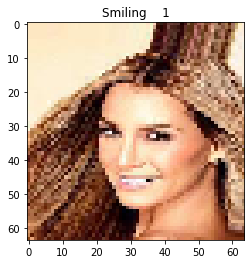

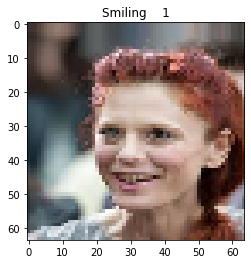

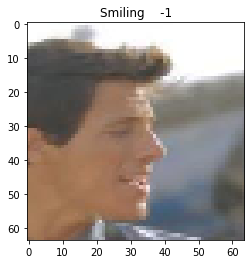

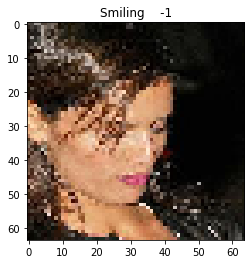

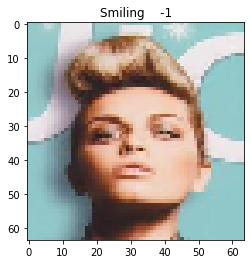

In [33]:
#displaying first 5 images with smiling attribute value for each image
for i in range(5):
    
    plt.imshow(x[i])
    plt.title(attribute_labels[-9]+ '  '+ '  '+y_df.iloc[i,31])
    plt.show()

# VAE Model:

VAE stands for Vartiational Autoencoder, It is one of the unsupervised learning model in neural networks. It can be applied on high dimensional data like images,audio,videos and texts.

Two main components in VAE are Encoder and Decoder

Encoder: Encoder converts input data into low dimensional latent space, which captures the underlying structure  of the data.

Whats differs from the traditional encoders to variational autoencoder is, in VAE instead of sending fixed sized latent vector into decoder, we send a sample generated from the probability distribution  using two vectors mean and standard deviation

Decoder: The work of decoder is to take the sample of latent dimensions generated by distribution and reconstruct the original image





# Encoder 

Encoder with three Conv2D layers. 
Batch Normalization after every layer.
Droping out 30 percent of neurons after each layer.

In [133]:
#encoder 
input_shape=(64,64,3)
latent_dim=200
encoder_input=layers.Input(shape=input_shape)
hidden_layer1=layers.Conv2D(32,3,strides=2,padding="same",activation='relu')(encoder_input)
batch_1=layers.BatchNormalization()(hidden_layer1)
dropout_1=layers.Dropout(0.3)(batch_1)
hidden_layer2=layers.Conv2D(64,3,strides=2,padding="same",activation='relu')(dropout_1)
batch_2=layers.BatchNormalization()(hidden_layer2)
dropout_2=layers.Dropout(0.3)(batch_2)
hidden_layer3=layers.Conv2D(128,3,strides=2,padding="same",activation='relu')(dropout_2)
batch_3=layers.BatchNormalization()(hidden_layer3)
dropout_3=layers.Dropout(0.3)(batch_3)
decoder_input_shape=dropout_3.shape

flat_layer=layers.Flatten()(dropout_3)

dense_layer1=layers.Dense(128,activation='relu')(flat_layer)

latent_mean=layers.Dense(latent_dim)(flat_layer)
latent_std=layers.Dense(latent_dim)(flat_layer)
class Sampling(layers.Layer):
    def call(self, inputs):
        latent_mean, latent_std = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(latent_mean))
        return latent_mean + tf.exp(0.5 * latent_std) * epsilon

z = Sampling()([latent_mean, latent_std])

encoder = keras.Model(encoder_input, [latent_mean, latent_std, z])
encoder.summary()




Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 32, 32, 32)   896         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_31 (BatchN  (None, 32, 32, 32)  128         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_26 (Dropout)           (None, 32, 32, 32)   0           ['batch_normalization_31[0

# Decoder

In [134]:
#decoder

decoder_input=layers.Input(shape=latent_dim)
dense_layer_D=layers.Dense(decoder_input_shape[1]*decoder_input_shape[2]*decoder_input_shape[3], activation='relu')(decoder_input)
reshape_layer=layers.Reshape((decoder_input_shape[1],decoder_input_shape[2],decoder_input_shape[3]))(dense_layer_D)
hidden_layer1_D=layers.Conv2DTranspose(64,3,strides=2,padding="same",activation='relu')(reshape_layer)
batch_1D =layers.BatchNormalization()(hidden_layer1_D)
dropout_1D=layers.Dropout(0.3)(batch_1D)
hidden_layer2_D=layers.Conv2DTranspose(64,3,strides=2,padding="same",activation='relu')(dropout_1D)
batch_2D =layers.BatchNormalization()(hidden_layer2_D)
dropout_2D=layers.Dropout(0.3)(batch_2D)
decoder_output =layers.Conv2DTranspose(3,3,strides=2,padding="same",activation='sigmoid')(dropout_2D)
decoder =keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 200)]             0         
                                                                 
 dense_29 (Dense)            (None, 8192)              1646592   
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 16, 16, 64)       73792     
 Transpose)                                                      
                                                                 
 batch_normalization_34 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_29 (Dropout)        (None, 16, 16, 64)        0  

## Loss Function

In [135]:
#loss function from tensorflow vae documentation
#https://keras.io/examples/generative/vae/#display-a-grid-of-sampled-digits
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## MODEL

In [136]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
vae.fit(x, epochs=50, batch_size=64)

Epoch 1/50
313/313 [==============================] - 47s 137ms/step - loss: 2522.1837 - reconstruction_loss: 2344.0500 - kl_loss: 43.2124
Epoch 2/50
313/313 [==============================] - 43s 138ms/step - loss: 2251.5717 - reconstruction_loss: 2177.7700 - kl_loss: 57.5028
Epoch 3/50
313/313 [==============================] - 48s 155ms/step - loss: 2201.8866 - reconstruction_loss: 2136.7026 - kl_loss: 58.5458
Epoch 4/50
313/313 [==============================] - 53s 168ms/step - loss: 2183.5134 - reconstruction_loss: 2119.6421 - kl_loss: 59.4204
Epoch 5/50
313/313 [==============================] - 56s 178ms/step - loss: 2171.1982 - reconstruction_loss: 2110.6990 - kl_loss: 60.0873
Epoch 6/50
313/313 [==============================] - 61s 196ms/step - loss: 2165.8863 - reconstruction_loss: 2104.4182 - kl_loss: 60.8772
Epoch 7/50
313/313 [==============================] - 71s 227ms/step - loss: 2161.1023 - reconstruction_loss: 2100.2769 - kl_loss: 61.5187
Epoch 8/50
313/313 [=======

## Random faces generated with 2 latent dimensions

1/1 [==============================] - 1s 551ms/step


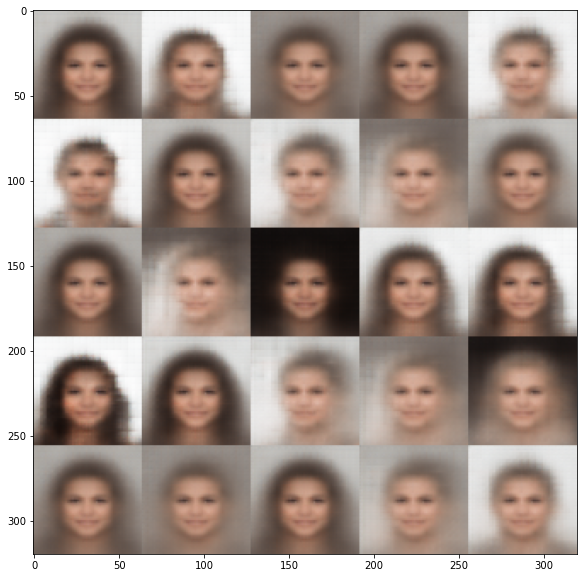

In [90]:
#when latent dimensions are 2
import matplotlib.pyplot as plt
import numpy as np

number_of_images = 5
img_size = 64
figure = np.zeros((img_size*number_of_images,img_size*number_of_images, 3))
z=np.random.normal(size=(number_of_images*number_of_images, latent_dim))
reconstruct = vae.decoder.predict(z)

for i in range(number_of_images):
    for j in range(number_of_images):
        img = reconstruct[i*number_of_images + j]
        figure[i*img_size: (i + 1)*img_size,
               j*img_size: (j + 1)*img_size] = img


plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis()
plt.show()


625/625 [==============================] - 17s 27ms/step


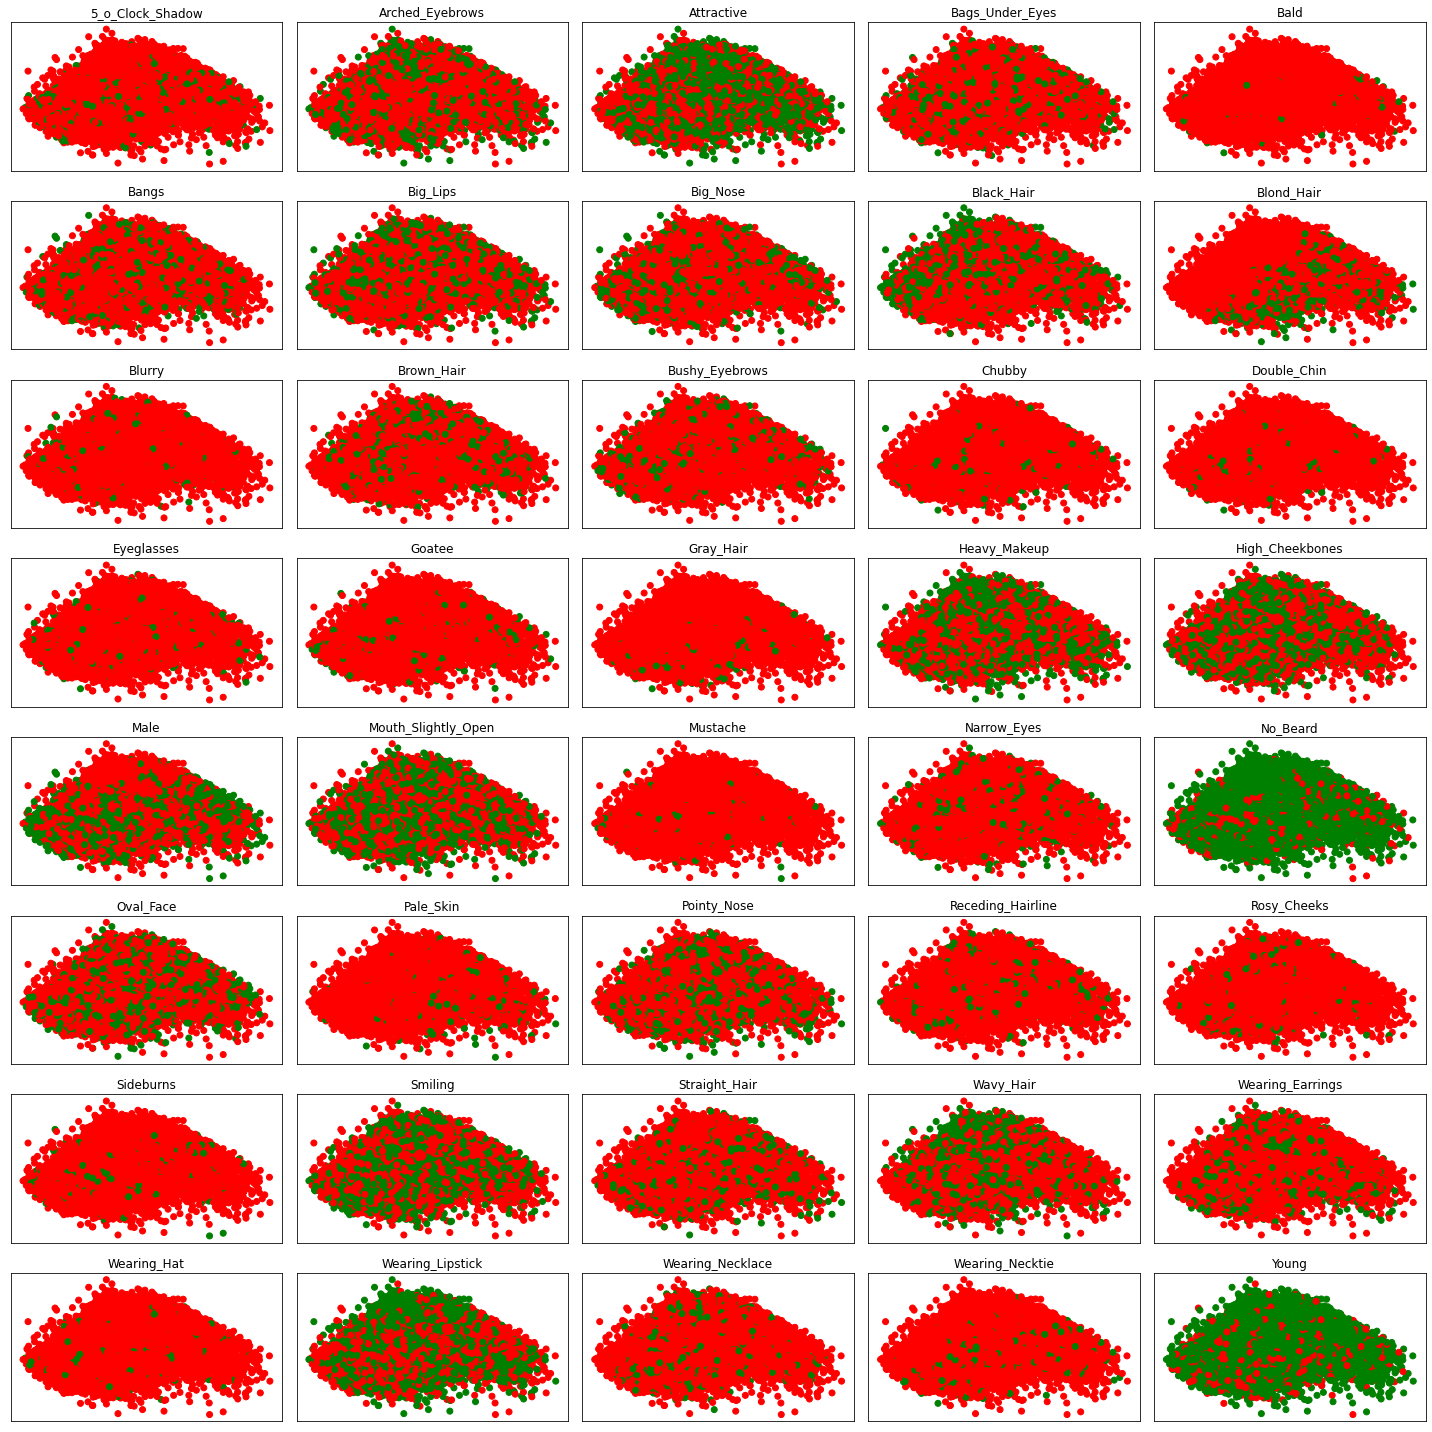

In [103]:
from tensorflow.keras import backend as K
attr=0
fig, axs = plt.subplots(nrows=8, ncols=5, figsize=(20, 20))
latent_mean, _, _ = vae.encoder.predict(x)
# Loop over the subplots and plot the scatter plot for each class
for i in range(8):
    for j in range(5):
        c=y_df.iloc[:,attr]
        colors = {'1': 'green', '-1': 'red'}
        y_color=c.map(colors)
        axs[i, j].scatter(latent_mean[:, 0], latent_mean[:, 1],c=y_color)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(attribute_labels[attr])

        attr+=1
        
plt.tight_layout()
plt.show()


## Random faces generated with 20 latent dimensions


1/1 [==============================] - 0s 50ms/step


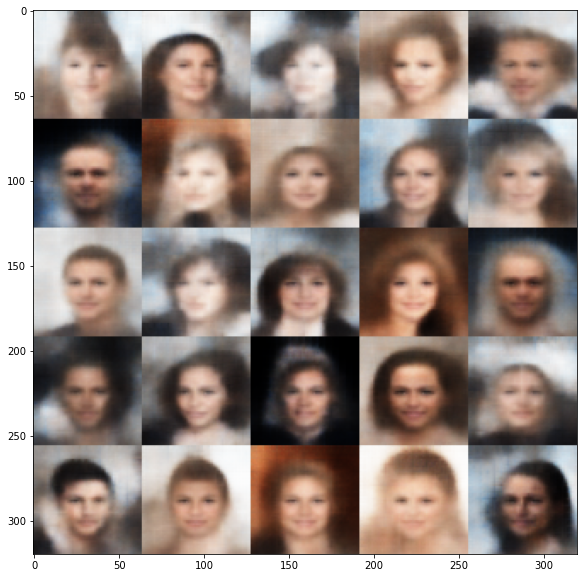

In [113]:
#when latent dimensions are 20
import matplotlib.pyplot as plt
import numpy as np

number_of_images = 5
img_size = 64
figure = np.zeros((img_size*number_of_images,img_size*number_of_images, 3))
z=np.random.normal(size=(number_of_images*number_of_images, latent_dim))
reconstruct = vae.decoder.predict(z)

for i in range(number_of_images):
    for j in range(number_of_images):
        img = reconstruct[i*number_of_images + j]
        figure[i*img_size: (i + 1)*img_size,
               j*img_size: (j + 1)*img_size] = img


plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis()
plt.show()


In [115]:
#capturing latent mean of 20 dim
latent_mean_20dim, _, _ = vae.encoder.predict(x)

625/625 [==============================] - 14s 22ms/step


C:\Users\navee\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\navee\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


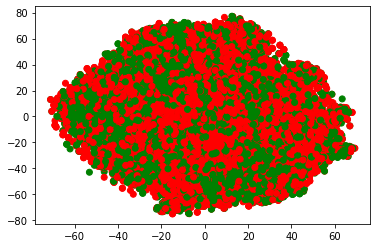

In [116]:
from sklearn.manifold import TSNE
c=y_df.iloc[:,-9]
colors = {'1': 'green', '-1': 'red'}

# map each value in the series to a color
y_color=c.map(colors)

tsne = TSNE(n_components=2, perplexity=30)
latent_tsne = tsne.fit_transform(latent_mean_20dim)

plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=y_color)
plt.show()

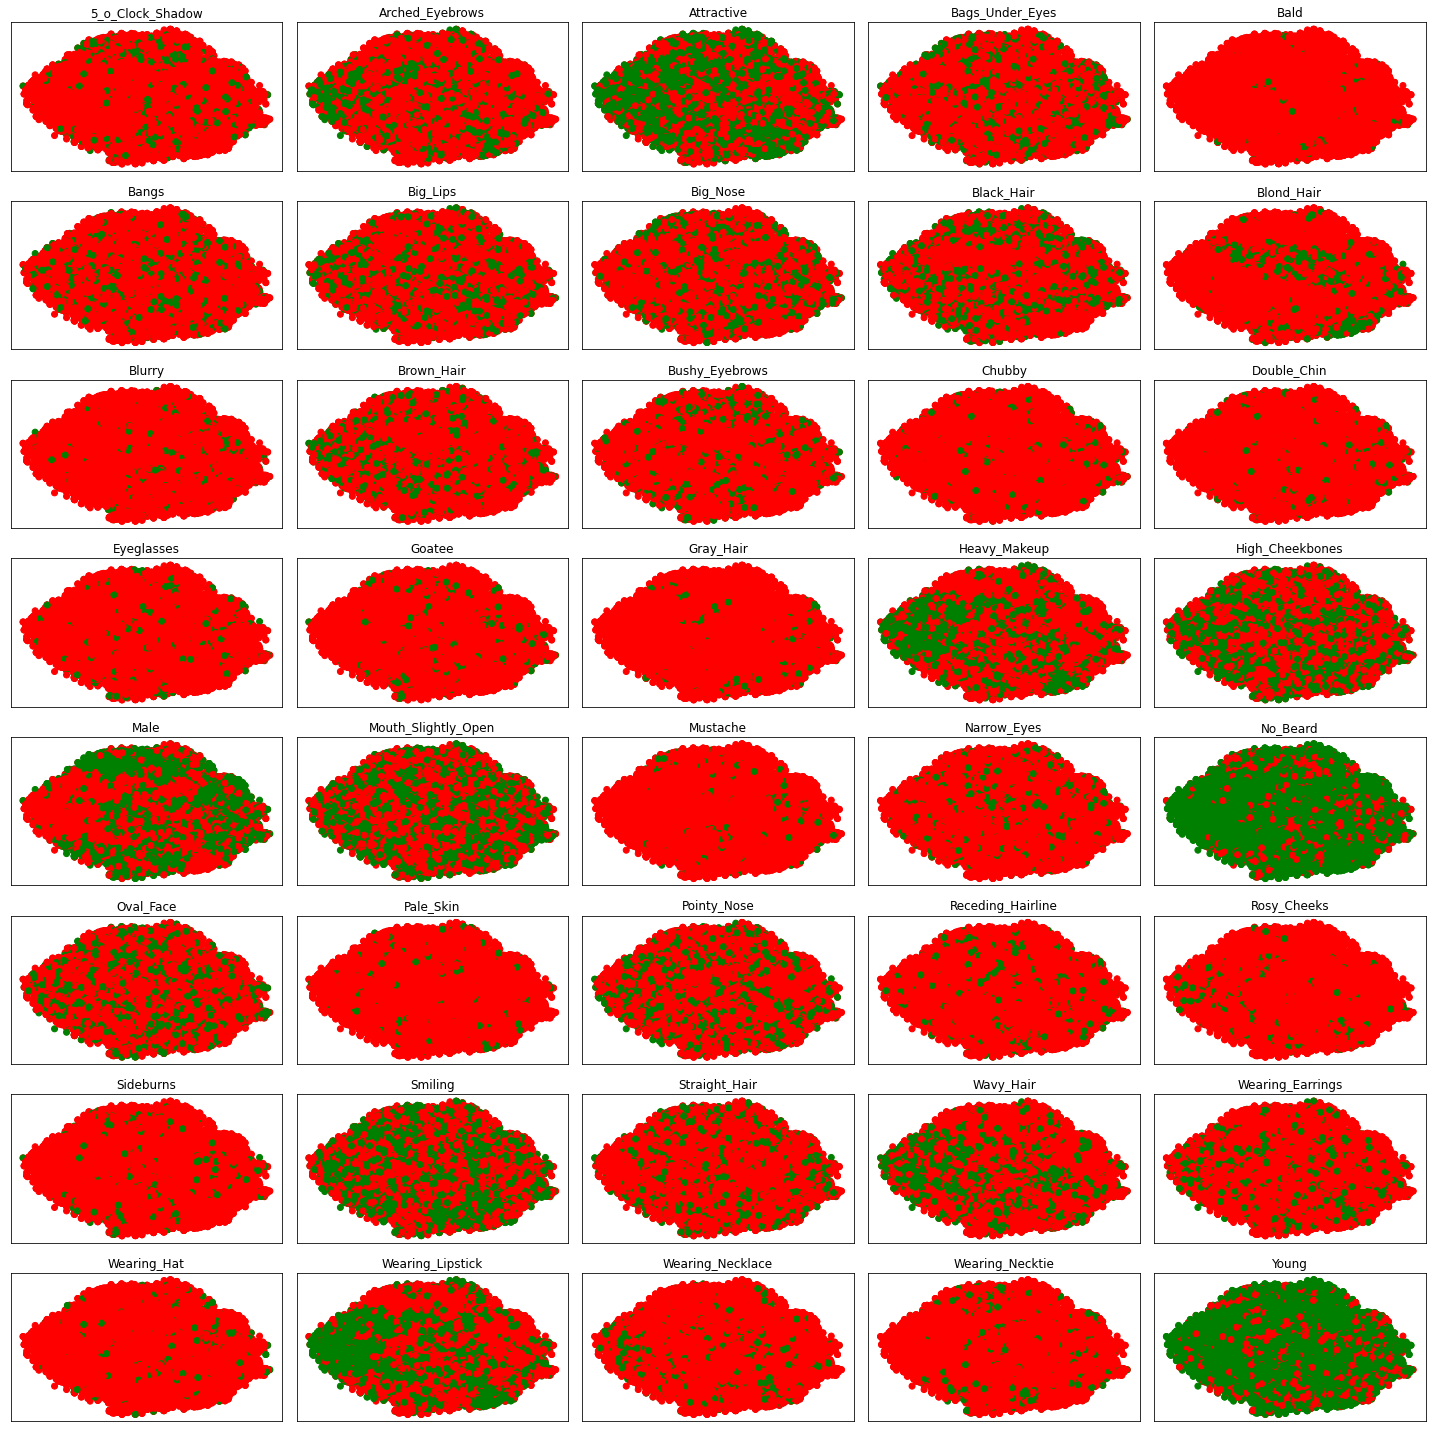

In [117]:
from tensorflow.keras import backend as K
attr=0
fig, axs = plt.subplots(nrows=8, ncols=5, figsize=(20, 20))
#latent_mean, _, _ = vae.encoder.predict(x)
# Loop over the subplots and plot the scatter plot for each class
for i in range(8):
    for j in range(5):
        c=y_df.iloc[:,attr]
        colors = {'1': 'green', '-1': 'red'}
        y_color=c.map(colors)
        axs[i, j].scatter(latent_tsne[:, 0], latent_tsne[:, 1],c=y_color)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(attribute_labels[attr])

        attr+=1
        
plt.tight_layout()
plt.show()


## Random faces generated with 100 latent dimensions


In [129]:
#capturing latent mean of 100 dim
latent_mean_100dim, _, _ = vae.encoder.predict(x)

625/625 [==============================] - 15s 24ms/step


1/1 [==============================] - 0s 43ms/step


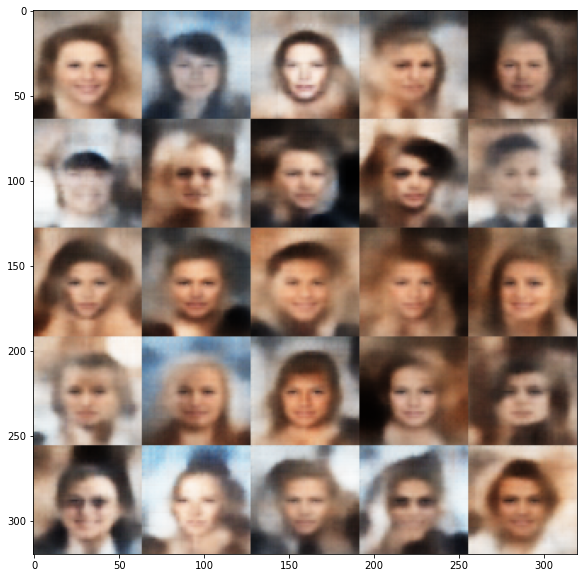

In [131]:
#when latent dimensions are 100
import matplotlib.pyplot as plt
import numpy as np

number_of_images = 5
img_size = 64
figure = np.zeros((img_size*number_of_images,img_size*number_of_images, 3))
z=np.random.normal(size=(number_of_images*number_of_images, latent_dim))
reconstruct = vae.decoder.predict(z)

for i in range(number_of_images):
    for j in range(number_of_images):
        img = reconstruct[i*number_of_images + j]
        figure[i*img_size: (i + 1)*img_size,
               j*img_size: (j + 1)*img_size] = img


plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis()
plt.show()


## Random faces generated with 200 latent dimensions


In [224]:
#capturing latent space values of 200 dim
latent_mean_200dim,latent_std_200dim,latent_sample_200dim = vae.encoder.predict(x)

625/625 [==============================] - 30s 48ms/step


1/1 [==============================] - 0s 254ms/step


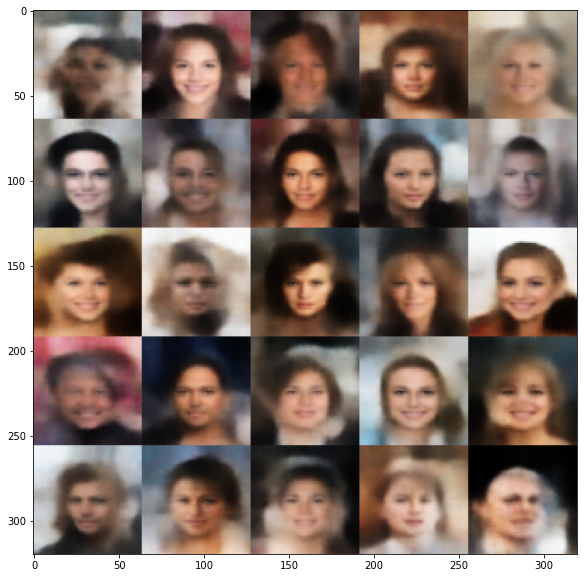

In [137]:
#when latent dimensions are 200
import matplotlib.pyplot as plt
import numpy as np

number_of_images = 5
img_size = 64
figure = np.zeros((img_size*number_of_images,img_size*number_of_images, 3))
z=np.random.normal(size=(number_of_images*number_of_images, latent_dim))
reconstruct = vae.decoder.predict(z)

for i in range(number_of_images):
    for j in range(number_of_images):
        img = reconstruct[i*number_of_images + j]
        figure[i*img_size: (i + 1)*img_size,
               j*img_size: (j + 1)*img_size] = img


plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis()
plt.show()


Text(0.5, 1.0, '200 Dimensions')

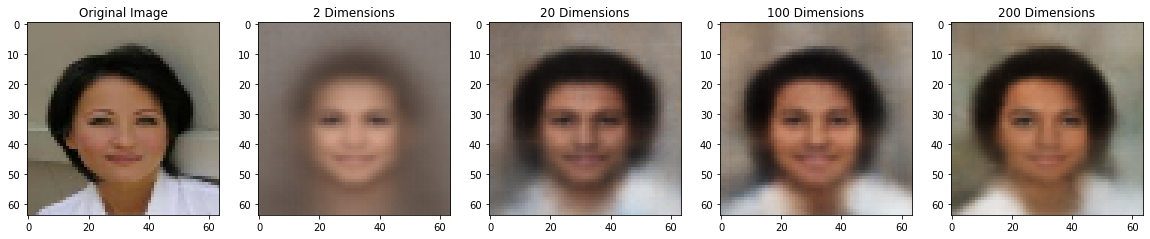

In [139]:
f, axs = plt.subplots(1, 5, figsize=(20, 20))

axs[0].imshow(x[100])
axs[0].set_title('Original Image')
axs[1].imshow(reconstructed_image_2dim.squeeze())
axs[1].set_title('2 Dimensions')
axs[2].imshow(reconstructed_image_20dim.squeeze())
axs[2].set_title('20 Dimensions')
axs[3].imshow(reconstructed_image_100dim.squeeze())
axs[3].set_title('100 Dimensions')
axs[4].imshow(reconstructed_image_200dim.squeeze())
axs[4].set_title('200 Dimensions')

# Extracting Attribute:

# Intuition: 

As one can see primary objective of the model is to extract the attribute vectors of each attribute to enchnace that particluar aspect of the image. The approach I did is to extract that particular feature by taking mean of the latent space for images with that attribute and also for images without that attribute. Now by subtracting no attribute vector mean from attribute vector mean gives the the attribute vector mean  

## Smile Attribute

1/1 [==============================] - 0s 24ms/step


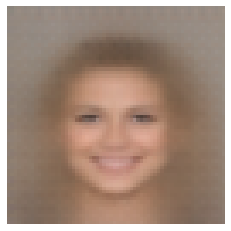

In [140]:
#extracting smile vector
attribute='Smiling'
attribute_filter=(y_df[attribute] == '1')
images_with_attribute=x[attribute_filter]
no_attribute_filter=(y_df[attribute] == '-1')
images_with_no_attribute=x[no_attribute_filter]
#latent space for all smilling images
encoded_with_attribute = vae.encoder.predict(images_with_attribute)
#latent space for all non smiling images
encoded_with_no_attribute = vae.encoder.predict(images_with_no_attribute)
#finding the mean for both smile and no smile latent spaces
mean_attribute = np.mean(encoded_with_attribute[2], axis=0)
mean_no_attribute = np.mean(encoded_with_no_attribute[2],axis=0)
attribute_vector = mean_attribute - mean_no_attribute
smile_vector=np.reshape(attribute_vector, (1, 200))

attribute_image=vae.decoder.predict(smile_vector)
plt.imshow(attribute_image.squeeze())
plt.axis('off');

In [223]:
latent_features[2].shape

(1, 200)

In [150]:
#smile enhancing
latent_features = encoder.predict(np.expand_dims(images_with_no_attribute[450],0))
image_construct = vae.decoder.predict(latent_features[2])

k = 2 # Weighting of attribute vector
latent_features_enhanced = latent_features[2] + (k * smile_vector)
enhanced_image_constuct = vae.decoder.predict(latent_features_enhanced)

1/1 [==============================] - 0s 30ms/step


In [159]:
#smile dimnishing
latent_features = encoder.predict(np.expand_dims(images_with_attribute[2000],0))
image_construct_inverse = vae.decoder.predict(latent_features[2])

latent_features_enhanced = latent_features[2] + (-k * smile_vector)
diminshed_image_constuct = vae.decoder.predict(latent_features_enhanced)

1/1 [==============================] - 0s 43ms/step


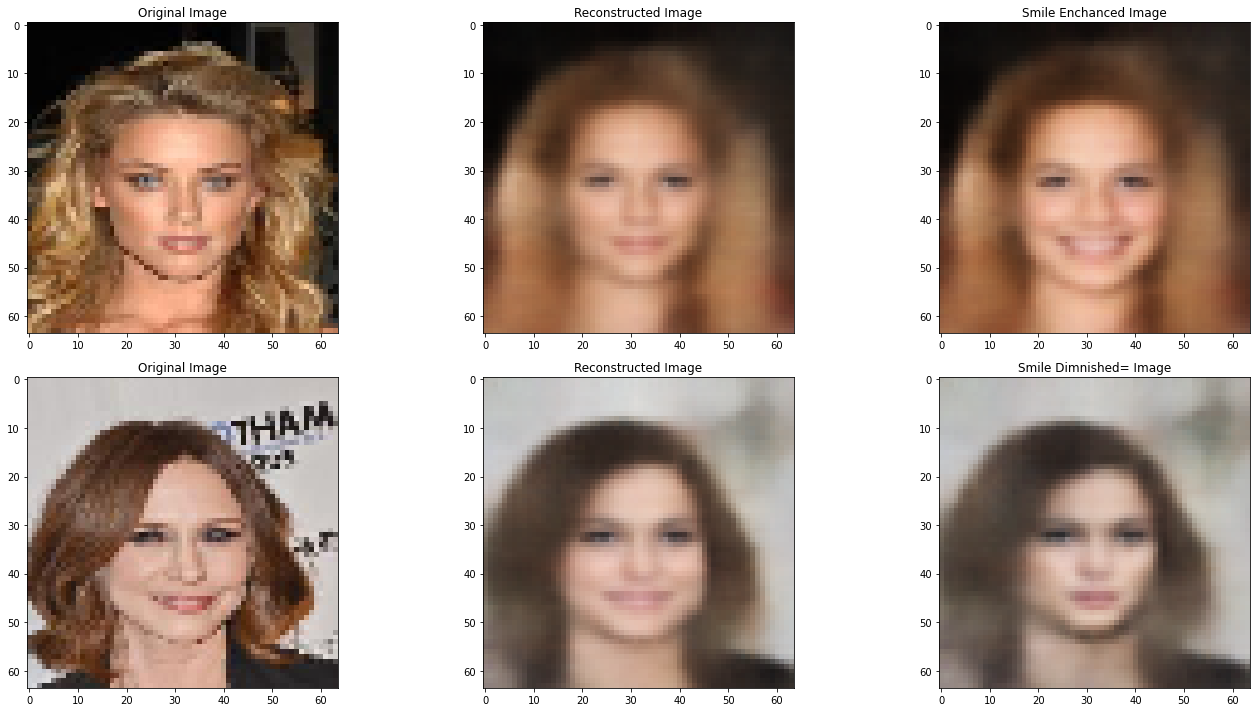

In [162]:
f, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0,0].imshow(images_with_no_attribute[450])
axs[0,0].set_title('Original Image')
axs[0,1].imshow(image_construct.squeeze())
axs[0,1].set_title('Reconstructed Image')
axs[0,2].imshow(enhanced_image_constuct.squeeze())
axs[0,2].set_title('Smile Enchanced Image')
axs[1,0].imshow(images_with_attribute[2000])
axs[1,0].set_title('Original Image')
axs[1,1].imshow(image_construct_inverse.squeeze())
axs[1,1].set_title('Reconstructed Image')
axs[1,2].imshow(diminshed_image_constuct.squeeze())
axs[1,2].set_title('Smile Dimnished= Image')
   
plt.tight_layout();

## Bald Attribute

1/1 [==============================] - 0s 90ms/step


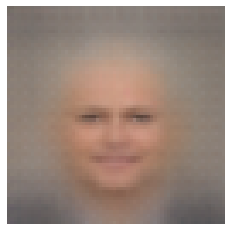

In [226]:
#extracting bald vector
attribute='Bald'
attribute_filter=(y_df[attribute] == '1')
images_with_attribute=x[attribute_filter]
no_attribute_filter=(y_df[attribute] == '-1')
images_with_no_attribute=x[no_attribute_filter]
#latent space for all bald images
encoded_with_attribute = vae.encoder.predict(images_with_attribute)
#latent space for all hair images
encoded_with_no_attribute = vae.encoder.predict(images_with_no_attribute)
#finding the mean for both bald and hair latent spaces
mean_attribute = np.mean(encoded_with_attribute[2], axis=0)
mean_no_attribute = np.mean(encoded_with_no_attribute[2],axis=0)
attribute_vector = mean_attribute - mean_no_attribute
bald_vector=np.reshape(attribute_vector, (1, 200))

attribute_image=vae.decoder.predict(bald_vector)
plt.imshow(attribute_image.squeeze())
plt.axis('off');

In [227]:
#hair enhancing
latent_features = encoder.predict(np.expand_dims(images_with_attribute[7],0))
image_construct = vae.decoder.predict(latent_features[2])

k = -1.2 # Weighting of attribute vector
latent_features_enhanced = latent_features[2] + (k * bald_vector)
enhanced_image_constuct = vae.decoder.predict(latent_features_enhanced)


1/1 [==============================] - 0s 50ms/step


In [229]:
#hair dimnishing
latent_features = encoder.predict(np.expand_dims(images_with_no_attribute[2000],0))
image_construct_inverse = vae.decoder.predict(latent_features[2])

latent_features_enhanced = latent_features[2] + (-k * bald_vector)
diminshed_image_constuct = vae.decoder.predict(latent_features_enhanced)

1/1 [==============================] - 0s 49ms/step


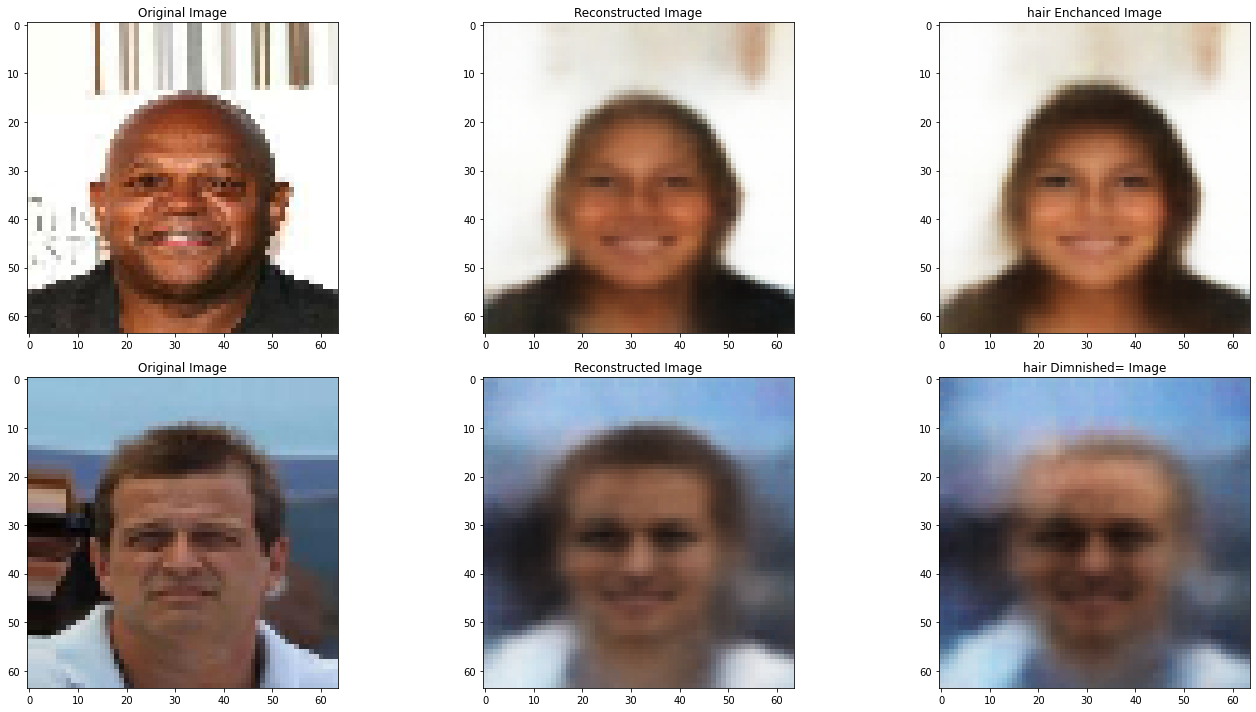

In [230]:
f, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0,0].imshow(images_with_attribute[7])
axs[0,0].set_title('Original Image')
axs[0,1].imshow(image_construct.squeeze())
axs[0,1].set_title('Reconstructed Image')
axs[0,2].imshow(enhanced_image_constuct.squeeze())
axs[0,2].set_title('hair Enchanced Image')
axs[1,0].imshow(images_with_no_attribute[2000])
axs[1,0].set_title('Original Image')
axs[1,1].imshow(image_construct_inverse.squeeze())
axs[1,1].set_title('Reconstructed Image')
axs[1,2].imshow(diminshed_image_constuct.squeeze())
axs[1,2].set_title('hair Dimnished= Image')
   
plt.tight_layout();

## Attractive Attribute

1/1 [==============================] - 0s 91ms/step


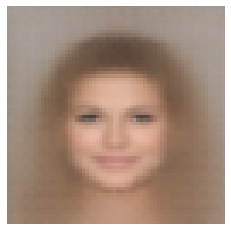

In [167]:
#extracting Attractive vector
attribute='Attractive'
attribute_filter=(y_df[attribute] == '1')
images_with_attribute=x[attribute_filter]
no_attribute_filter=(y_df[attribute] == '-1')
images_with_no_attribute=x[no_attribute_filter]
#latent space for all Attractive images
encoded_with_attribute = vae.encoder.predict(images_with_attribute)
#latent space for all non Attractive images
encoded_with_no_attribute = vae.encoder.predict(images_with_no_attribute)
#finding the mean for both Attractive and non Attractive latent spaces
mean_attribute = np.mean(encoded_with_attribute[2], axis=0)
mean_no_attribute = np.mean(encoded_with_no_attribute[2],axis=0)
attribute_vector = mean_attribute - mean_no_attribute
attractive_vector=np.reshape(attribute_vector, (1, 200))

attribute_image=vae.decoder.predict(attractive_vector)
plt.imshow(attribute_image.squeeze())
plt.axis('off');

In [185]:
#enhancing attractiveness
latent_features = encoder.predict(np.expand_dims(images_with_no_attribute[5000],0))
image_construct = vae.decoder.predict(latent_features[2])

k = 2 # Weighting of attribute vector
latent_features_enhanced = latent_features[2] + (k * attractive_vector)
enhanced_image_construct = vae.decoder.predict(latent_features_enhanced)

1/1 [==============================] - 0s 70ms/step


In [186]:
#attractive dimnishing
latent_features = encoder.predict(np.expand_dims(images_with_attribute[1000],0))
image_construct_inverse = vae.decoder.predict(latent_features[2])

latent_features_enhanced = latent_features[2] + (-k*2* attractive_vector)
diminshed_image_construct = vae.decoder.predict(latent_features_enhanced)

1/1 [==============================] - 0s 70ms/step


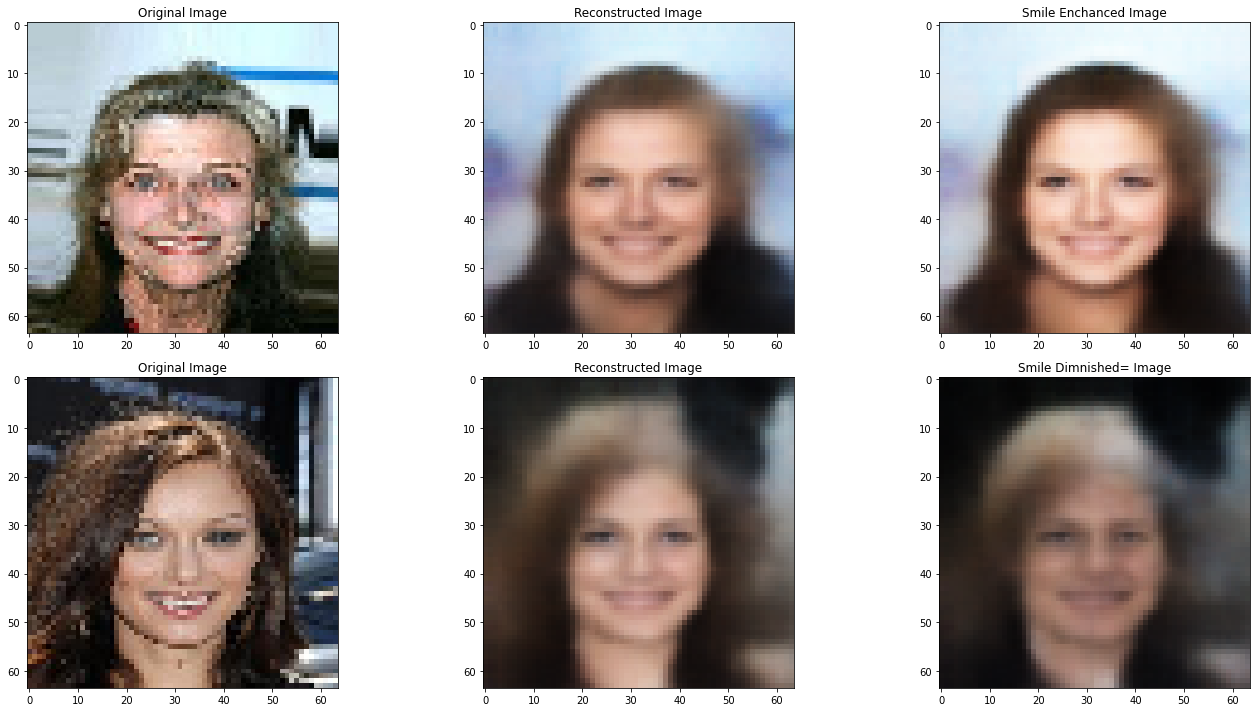

In [187]:
f, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0,0].imshow(images_with_no_attribute[5000])
axs[0,0].set_title('Original Image')
axs[0,1].imshow(image_construct.squeeze())
axs[0,1].set_title('Reconstructed Image')
axs[0,2].imshow(enhanced_image_construct.squeeze())
axs[0,2].set_title('Smile Enchanced Image')
axs[1,0].imshow(images_with_attribute[1000])
axs[1,0].set_title('Original Image')
axs[1,1].imshow(image_construct_inverse.squeeze())
axs[1,1].set_title('Reconstructed Image')
axs[1,2].imshow(diminshed_image_construct.squeeze())
axs[1,2].set_title('Smile Dimnished= Image')
   
plt.tight_layout();

In [83]:
attribute_filter=(y_df['Smiling'] == '-1') & (y_df['Bald'] == '1') & (y_df['Attractive'] == '-1')
images_with_attribute=x[attribute_filter]

In [84]:
#adding multiple attribute vectors 
latent_features = encoder.predict(np.expand_dims(images_with_attribute[3],0))
image_construct = vae.decoder.predict(latent_features[2])

k = 1 # Weighting of attribute vector
latent_features_enhanced = latent_features[2] + (k * attractive_vector)+(2.5*smile_vector)+(-k*bald_vector)
enhanced_image_constuct = vae.decoder.predict(latent_features_enhanced)

1/1 [==============================] - 0s 63ms/step


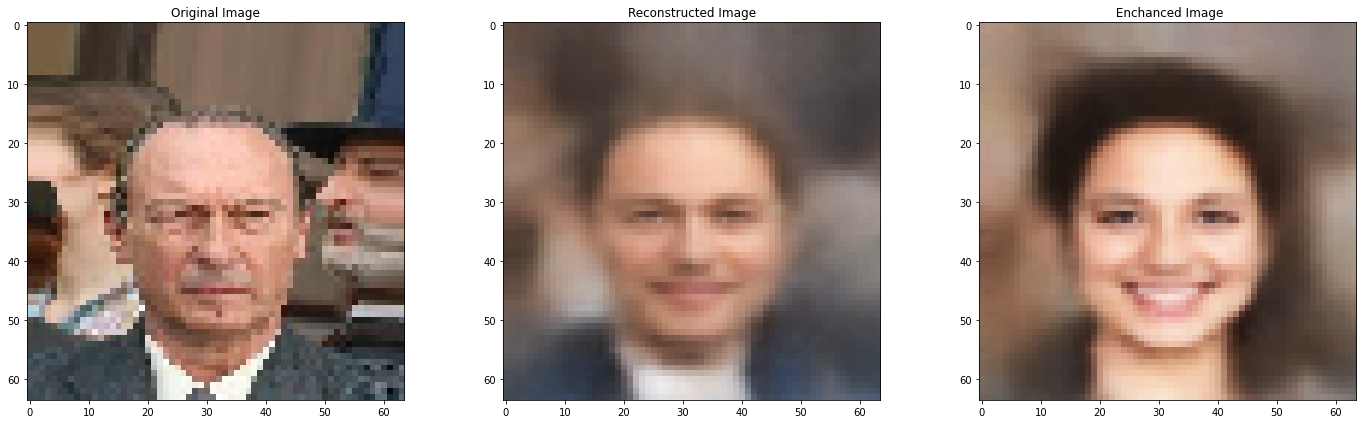

In [85]:
f, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(images_with_attribute[3])
axs[0].set_title('Original Image')
axs[1].imshow(image_construct.squeeze())
axs[1].set_title('Reconstructed Image')
axs[2].imshow(enhanced_image_constuct.squeeze())
axs[2].set_title(' Enchanced Image')
   
plt.tight_layout();

## Face Morphing

1/1 [==============================] - 0s 70ms/step


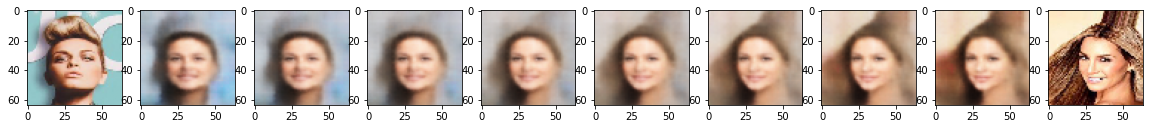

In [205]:
#face morphing
z_1=vae.encoder.predict(np.expand_dims(x[4],0))
z_2=vae.encoder.predict(np.expand_dims(x[0],0))
factors=np.linspace(0, 1, 9)
f, axs = plt.subplots(1, 10, figsize=(20, 10))
axs[0].imshow(x[4])
i=0
for factor in factors:
    i+=1
    z=(1-factor)*z_1[2]+(factor)*z_2[2]
    morphed=vae.decoder.predict(z)
    axs[i].imshow(morphed.squeeze())
axs[i].imshow(x[0])

1/1 [==============================] - 0s 70ms/step


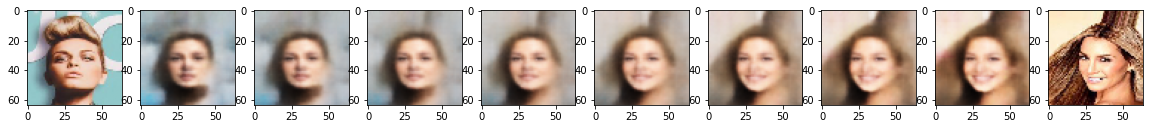

In [208]:
#face morphing with extra enhancing from attribute vectors
z_1=vae.encoder.predict(np.expand_dims(x[4],0))
z_2=vae.encoder.predict(np.expand_dims(x[0],0))
factors=np.linspace(0, 1, 9)
smile=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
f, axs = plt.subplots(1, 10, figsize=(20, 10))
axs[0].imshow(x[4])
i=0
for j,factor in enumerate(factors):
    i+=1
    z=(1-factor)*z_1[2]+(factor)*z_2[2]+smile[j]*smile_vector
    morphed=vae.decoder.predict(z)
    axs[i].imshow(morphed.squeeze())
axs[i].imshow(x[0])

# Drawbacks of the Model:

While extracting an attribute vector, if one attribute has high collinearity with another attribute. One attribute vector will contain values that can impact the other attribute